In [11]:
#경고 끄기
import warnings
warnings.filterwarnings(action='ignore')

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='Malgun Gothic')

In [13]:
def getData():
    df2008 = pd.read_csv("C:/농수산가격데이터/1001배추/2008010120081231.csv")
    df2009 = pd.read_csv("C:/농수산가격데이터/1001배추/2009010120091231.csv")
    df2010 = pd.read_csv("C:/농수산가격데이터/1001배추/2010010120101231.csv")
    df2011 = pd.read_csv("C:/농수산가격데이터/1001배추/2011010120111231.csv")
    df2012 = pd.read_csv("C:/농수산가격데이터/1001배추/2012010120121231.csv")
    df2013 = pd.read_csv("C:/농수산가격데이터/1001배추/2013010120131231.csv")
    df2014 = pd.read_csv("C:/농수산가격데이터/1001배추/2014010120141231.csv")
    df2015 = pd.read_csv("C:/농수산가격데이터/1001배추/2015010120151231.csv")
    df2016 = pd.read_csv("C:/농수산가격데이터/1001배추/2016010120161231.csv")
    df2017 = pd.read_csv("C:/농수산가격데이터/1001배추/2017010120171231.csv")
    df2018 = pd.read_csv("C:/농수산가격데이터/1001배추/2018010120181231.csv")
    return pd.concat((df2008, df2009, df2010, df2011, df2012, df2013, df2014, df2015, df2016, df2017, df2018), axis=0)

In [14]:
def pricTransform(df):
    #Kg당 가격(kgperprice)
    df['kgperprice'] = ''
    #총거래가격(totalprice) = 거래량(delngQy) * 가격(sbidpric)
    df['totalprice'] = ''
    #총량(totalweight) = 거래단량(delngprut) * 거래량(delngQy) * 단위
    df['totalweight'] = ''

    df11 = df[(df['stdunitnewcode']==11)]
    df12 = df[(df['stdunitnewcode']==12)]
    df13 = df[(df['stdunitnewcode']==13)]
    for df11 in [df11]:
        df11['kgperprice'] = df11['sbidpric'] / df11['delngprut'] * 1000
        df11['totalweight'] = df11['delngprut'] * df11['delngqy'] / 1000
    for df12 in [df12]:
        df12['kgperprice'] = df12['sbidpric'] / df12['delngprut']
        df12['totalweight'] = df12['delngprut'] * df12['delngqy']
    for df13 in [df13]:
        df13['kgperprice'] = df13['sbidpric'] / df13['delngprut'] / 1000
        df13['totalweight'] = df13['delngprut'] * df13['delngqy'] / 1000
    df = pd.concat([df11, df12, df13])

    for df in [df]:
        df['totalprice'] = df['sbidpric'] * df['delngqy']
        
    return df

In [15]:
df = getData()

### 단량별 가격 sbidpric
- 거래단량 delngprut이 얼마에 거래됬는지 나타내는 변수
- sbidpric만으로는 g, kg, ton 단위가 너무 포괄적이기 때문에 kg당 가격으로 가공 필요

#### 컬럼추가
- Kg당 가격(kgperprice)
  - 가격(sbidpric) / 거래단량(delngprut)
  - 거래단위(stdunitnewcode)가 g(11)일경우 *1000, kg(12)일경우 그대로, ton(13)일경우 /1000
  - 하면 kgperprice가 됨
- 총거래가격(totalprice)
  - 거래량(delngQy) * 가격(sbidpric)
- 총량(totalweight)
  - 거래단량(delngprut) * 거래량(delngQy)
  - 거래단위(stdunitnewcode)가 g(11)일경우 /1000, kg(12)일경우 그대로, ton(13)일경우 *1000

In [16]:
df = pricTransform(df)

In [30]:
df[(df['kgperprice'] <= 100) & (df['stdqlitynewnm'] == '특')][['totalprice','sbidpric','totalweight','kgperprice','stdspciesnewnm','stdqlitynewnm','delngprut','delngqy','stdunitnewnm','delngde','whsalmrktnewnm']]

,totalprice,sbidpric,totalweight,kgperprice,stdspciesnewnm,stdqlitynewnm,delngprut,delngqy,stdunitnewnm,delngde,whsalmrktnewnm
550,60480,960,630.0,96.000000,기타,특,10.0,63,kg,20080103,부산엄궁농산물도매시장
555,9300,930,100.0,93.000000,기타,특,10.0,10,kg,20080103,부산엄궁농산물도매시장
840,39000,1000,390.0,100.000000,월동배추,특,10.0,39,kg,20080103,광주각화농산물도매시장
844,16000,800,200.0,80.000000,월동배추,특,10.0,20,kg,20080103,광주각화농산물도매시장
845,143200,800,1790.0,80.000000,월동배추,특,10.0,179,kg,20080103,광주각화농산물도매시장
846,4500,500,90.0,50.000000,월동배추,특,10.0,9,kg,20080103,광주각화농산물도매시장
987,36000,1500,480.0,75.000000,우거지,특,20.0,24,kg,20080103,안산농수산물도매시장
998,870000,1500,8700.0,100.000000,기타,특,15.0,580,kg,20080103,구리농수산물도매시장
1104,144000,1000,1440.0,100.000000,월동배추,특,10.0,144,kg,20080103,전주농수산물도매시장
1105,100000,1000,1000.0,100.000000,월동배추,특,10.0,100,kg,20080103,전주농수산물도매시장


(4809379, 47)
(19123, 47)


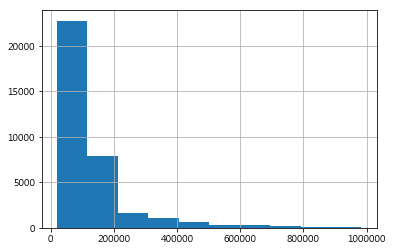

In [24]:
print(df.shape)
print(df[(df['kgperprice'] > 50000)].shape)
# df[(40000 >= df['kgperprice']) & (df['kgperprice'] >= 20000)]['kgperprice'].hist()
df[(df['kgperprice'] > 20000)]['kgperprice'].hist()
# df[(50000 >= df['kgperprice']) & (df['kgperprice'] >= 20000)][['kgperprice','stdqlitynewnm','stdunitnewnm','delngde','whsalmrktnewnm']]
# 5만 이상은 결측치라 판단 제거
df = df[(df['kgperprice'] <= 20000)]
# 0이하 제거
df = df[(df['kgperprice'] >= 0)]

### 경매 종류 선택 aucsecode-숫자 aucsenm-한글

- 1: 경매

- 2: 정가수의

  - 경쟁계약에 의하지 않고 임의로 상대를 선정하여 계약을 체결하는 것

- 3: 자기계산

  - 가격을 정하고 거래(정가매매)
      1. 출하자 가격과 수량 정해서 도매법인에게 의견전달
      2. 도매법인이 여러 구매자(중도매인, 매매참가인)에게 알려줌
      3. 구매 의향 있는 구매자 등장 시 거래성사

- 4: 매수도매

  - 직접 생산자와 출하약정을 맺고 물량을 구입해 중도매인에게 적정 가격으로 공급하는 제도

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(df['aucsenm'])

### 경락일자 delngde
### 거래단량 delngprut
### 거래량 delngqy

### 등급코드 stdqlitynewcode / stdqlitynewnm

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(df['stdqlitynewnm'],order = df['stdqlitynewnm'].value_counts().index)

#### 그룹별 중위수

In [ ]:
df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')][['stdqlitynewnm','kgperprice']].groupby("stdqlitynewnm").median()

In [ ]:
df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')][['stdqlitynewnm','totalweight']].groupby("stdqlitynewnm").median()

#### 그룹별 평균

In [ ]:
df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')][['stdqlitynewnm','kgperprice']].groupby("stdqlitynewnm").mean()

In [ ]:
df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')][['stdqlitynewnm','totalweight']].groupby("stdqlitynewnm").mean()

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdqlitynewnm', y='kgperprice', data=df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')])

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdqlitynewnm', y='totalweight', data=df[(df['stdqlitynewnm'] == '특') | (df['stdqlitynewnm'] == '무등급') | (df['stdqlitynewnm'] == '상') | (df['stdqlitynewnm'] == '보통')])

#### 그룹별 중위수

In [ ]:
df[(df['stdqlitynewnm'] != '특') & (df['stdqlitynewnm'] != '무등급') & (df['stdqlitynewnm'] != '상') & (df['stdqlitynewnm'] != '보통')][['stdqlitynewnm','kgperprice']].groupby("stdqlitynewnm").median()

#### 그룹별 평균

In [ ]:
df[(df['stdqlitynewnm'] != '특') & (df['stdqlitynewnm'] != '무등급') & (df['stdqlitynewnm'] != '상') & (df['stdqlitynewnm'] != '보통')][['stdqlitynewnm','kgperprice']].groupby("stdqlitynewnm").mean()

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdqlitynewnm', y='kgperprice', data=df[(df['stdqlitynewnm'] != '특') & (df['stdqlitynewnm'] != '무등급') & (df['stdqlitynewnm'] != '상') & (df['stdqlitynewnm'] != '보통')])

### 품종코드 stdspciesnewcode / stdspciesnewnm
- 구품종코드 stdspciescode stdspciesnm
- 품목코드 stdprdlstnewcode / stdprdlstnewnm
- 구품목코드 stdprdlstnm / stdprdlstcode 

In [8]:
df[['stdspciesnewcode','stdspciesnewnm']].drop_duplicates()

,stdspciesnewcode,stdspciesnewnm
89632,100199,기타
59862,100108,쌈(알배기)배추
335401,100103,김장(가을)배추
112783,100101,봄배추
205590,100105,고냉지배추
38848,100110,배추뿌리
58019,100109,우거지
5,100104,월동배추
13,100102,여름배추
254,100107,생채용배추


In [ ]:
df[][['stdqlitynewnm','kgperprice']].groupby("stdqlitynewnm").mean()

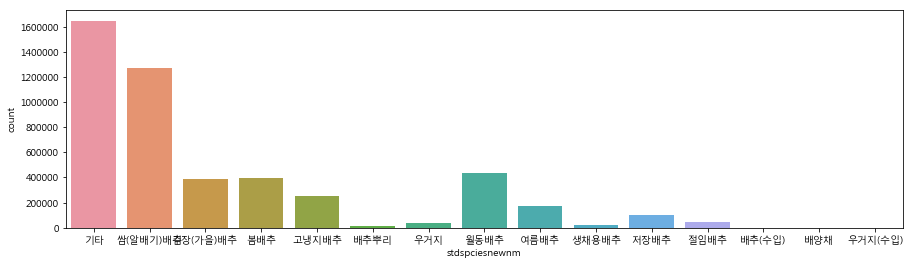

In [9]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(df['stdspciesnewnm'])

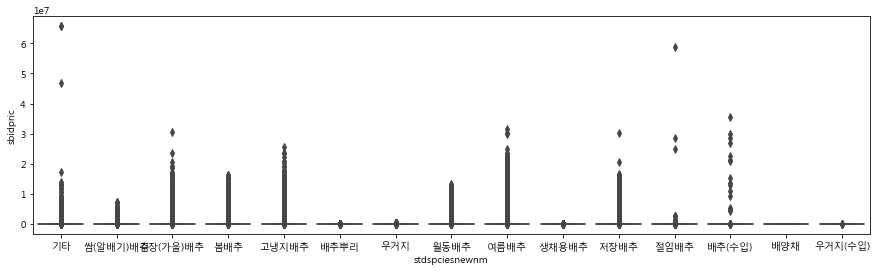

In [10]:
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdspciesnewnm', y='sbidpric', data=df)

### 산지코드 stdmtcnewcode / stdmtcnewnm
- 구산지코드 cprmtccode / cprmtcnm

In [ ]:
df[df['stdmtcnewnm'] == '전라남도 해남군'][['stdmtcnewcode','stdmtcnewnm']].drop_duplicates()

In [ ]:
df[['stdmtcnewcode','stdmtcnewnm']].drop_duplicates()

In [ ]:
df[['stdmtcnewcode','stdmtcnewnm']].drop_duplicates()

In [ ]:
df[df['stdmtcnewcode']==5600][['stdmtcnewnm','whsalmrktnewnm']]

In [ ]:
a = df[['stdmtcnewcode']]

## 글자 + 숫자 변환 필요

In [ ]:
df.dropna(inplace=True)

In [ ]:
df['stdmtcnewcode'] = df['stdmtcnewcode'].apply(lambda x : str(x))

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(df.groupby("stdmtcnewcode").filter(lambda x: len(x) > 50000)['stdmtcnewcode'])

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(df.groupby("stdmtcnewcode").filter(lambda x: len(x) > 50000)['stdmtcnewnm'])

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
fig = sns.boxplot(x='stdmtcnewnm', y='sbidpric', data=df)

### 단위코드 stdunitnewcode / stdunitnewnm

In [ ]:
df[['stdunitnewcode','stdunitnewnm']].drop_duplicates()

In [ ]:
sns.countplot(df[(df['stdunitnewcode'] != 12)]['stdunitnewnm'])

### 시장코드 whsalmrktnewcode / whsalmrktnewnm
- 구시장코드 whsalmrktcode / whsalmrktnm 
- 가락시장 코드 1005601(신) 110001(구)

In [ ]:
df[['whsalmrktnewcode','whsalmrktnewnm']].drop_duplicates()

In [ ]:
f, ax = plt.subplots(figsize=(15, 4))
sns.countplot(df.groupby("whsalmrktnewcode").filter(lambda x: len(x) > 250000)['whsalmrktnewnm'])